In [34]:
%matplotlib inline


Group analysis of resting-state fMRI with ICA: CanICA
=====================================================

An example applying CanICA to resting-state data. This example applies it
to 30 subjects of the ADHD200 datasets. Then it plots a map with all the
components together and an axial cut for each of the components separately.

CanICA is an ICA method for group-level analysis of fMRI data. Compared
to other strategies, it brings a well-controlled group model, as well as a
thresholding algorithm controlling for specificity and sensitivity with
an explicit model of the signal. The reference papers are:

    * G. Varoquaux et al. "A group model for stable multi-subject ICA on
      fMRI datasets", NeuroImage Vol 51 (2010), p. 288-299

    * G. Varoquaux et al. "ICA-based sparse features recovery from fMRI
      datasets", IEEE ISBI 2010, p. 1177

Pre-prints for both papers are available on hal
(http://hal.archives-ouvertes.fr)

<div class="alert alert-info"><h4>Note</h4><p>The use of the attribute `components_img_` from decomposition
    estimators is implemented from version 0.4.1.
    For older versions, unmask the deprecated attribute `components_`
    to get the components image using attribute `masker_` embedded in
    estimator.
    See the `section Inverse transform: unmasking data <unmasking_step>`.</p></div>



First we load the ADHD200 data
-------------------------------



In [35]:
import numpy as np
X=np.load('/storage/ADHD200/athena/NYU/All_Data.npy')

In [36]:
mask_img ='/storage/ADHD200/athena/NYU/ADHD200_mask_152_4mm.nii.gz'

from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask_img, 
                     standardize=True,
                     detrend=1,
                     smoothing_fwhm=6.,
                     memory="/storage/nilearn_cache", 
                     memory_level=2)
masker.fit()


/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/storage/nilearn_cache'", use "location='/storage/nilearn_cache'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)


NiftiMasker(detrend=1, dtype=None, high_pass=None, low_pass=None,
      mask_args=None,
      mask_img='/storage/ADHD200/athena/NYU/ADHD200_mask_152_4mm.nii.gz',
      mask_strategy='background',
      memory=Memory(location=/storage/nilearn_cache/joblib),
      memory_level=2, sample_mask=None, sessions=None, smoothing_fwhm=6.0,
      standardize=True, t_r=None, target_affine=None, target_shape=None,
      verbose=0)

Here we apply DL on the data
---------------------------------



In [37]:
from nilearn.decomposition import DictLearning

dict_learning = DictLearning(n_components=40, memory_level=2,
                             verbose=1,
                             random_state=0,
                             n_epochs=1)
dict_learning.masker_=masker


dict_learning._init_dict(X)
dict_learning._init_loadings(X)
dict_init = dict_learning.loadings_init_


#n_iter = ((50000 - 1) // 20 + 1) * 1
n_iter = 1200
print(n_iter)

from sklearn.decomposition import dict_learning_online
components, diction =dict_learning_online(X.T,n_components=40, 
                                            alpha=10,shuffle=1,dict_init=dict_init,
                                            batch_size=20,method="cd",n_iter=n_iter,
                                            verbose=1)


# Retrieve the independent components in brain space. Directly
# accesible through attribute `components_img_`. Note that this
# attribute is implemented from version 0.4.1. For older versions,
# see note section above for details.



/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.9s finished
/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been

1200
[dict_learning] ...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [38]:
print(X.shape)
print(components.shape)
print(diction.shape)

(37152, 28546)
(28546, 40)
(40, 37152)


In [39]:
np.save('/home/uga_qinglin/Documents/ADHD_DL/ADHD200_DL_diction.npy',diction)

In [28]:
import numpy as np

def plot_net(components):

    S = np.sqrt(np.sum(components ** 2, axis=1))
    S[S == 0] = 1
    components /= S[:, np.newaxis]

    # Flip signs in each composant so that positive part is l1 larger
    # than negative part. Empirically this yield more positive looking maps
    # than with setting the max to be positive.
    for component in components:
        if np.sum(component > 0) < np.sum(component < 0):
            component *= -1

    components_img=masker.inverse_transform(components) 
    
    from nilearn.plotting import plot_prob_atlas

    # Plot all ICA components together
    plot_prob_atlas(components_img, title='All ICA components')
    
    from nilearn.image import iter_img
    from nilearn.plotting import plot_stat_map, show

    for i, cur_img in enumerate(iter_img(components_img)):
        plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                      cut_coords=1, colorbar=False)

    show()

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/usr/local/lib/python3.5/dist-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, 

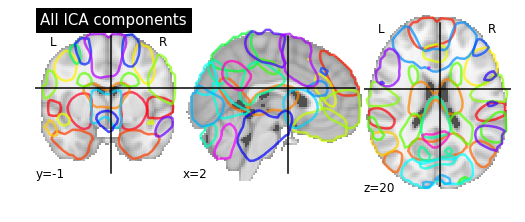

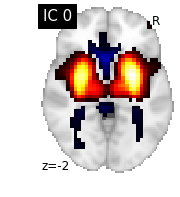

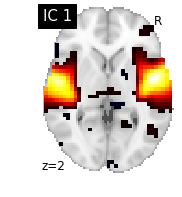

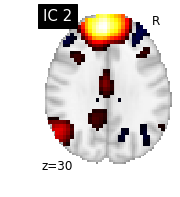

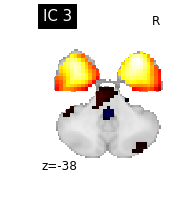

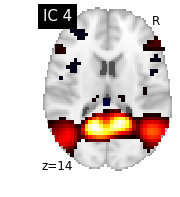

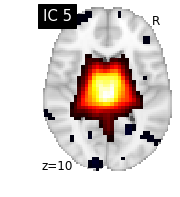

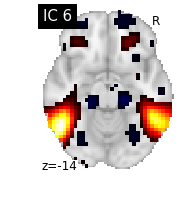

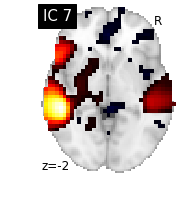

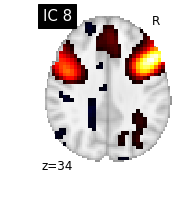

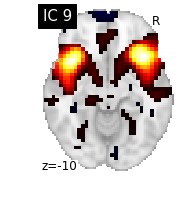

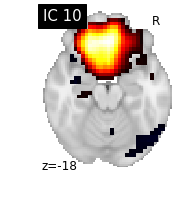

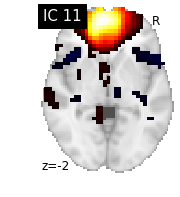

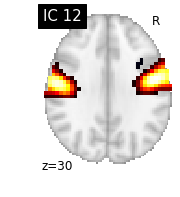

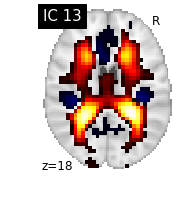

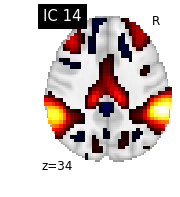

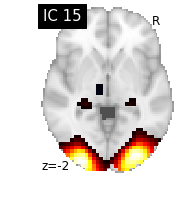

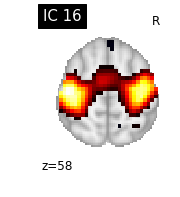

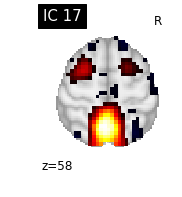

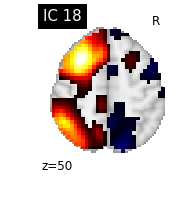

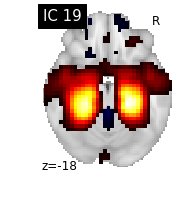

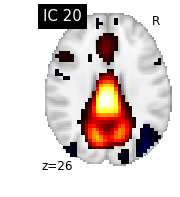

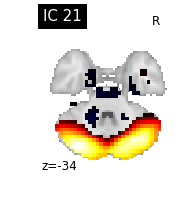

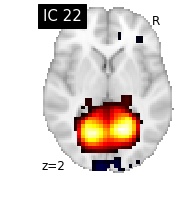

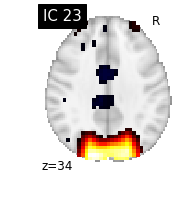

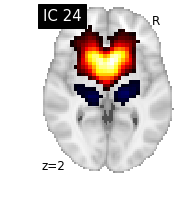

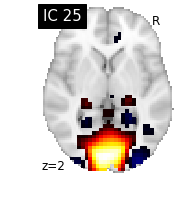

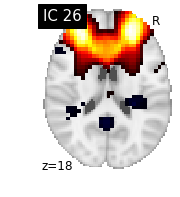

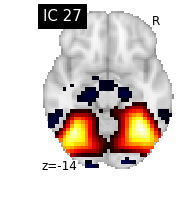

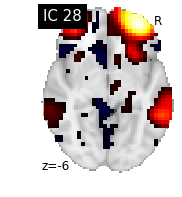

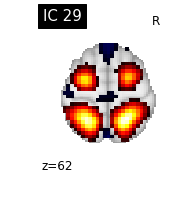

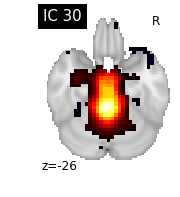

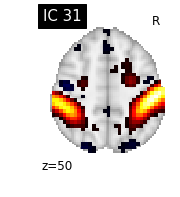

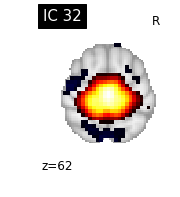

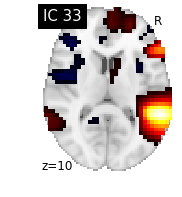

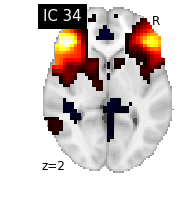

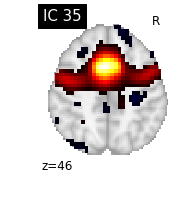

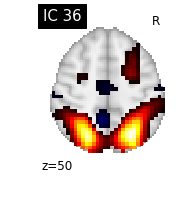

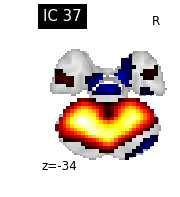

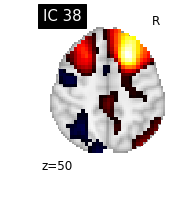

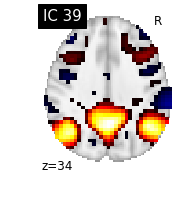

In [29]:
plot_net(components.T  )



In [32]:
from sklearn.linear_model import Lasso
clf = Lasso(alpha=0.001)
clf.fit(diction.T,X)



Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

/usr/local/lib/python3.5/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/usr/local/lib/python3.5/dist-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)
/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, 

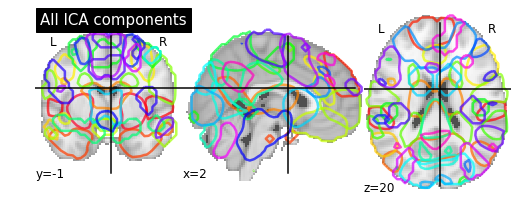

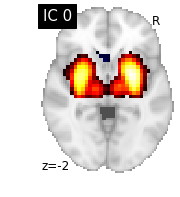

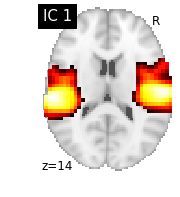

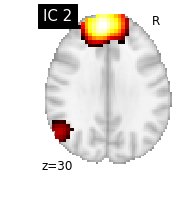

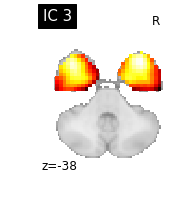

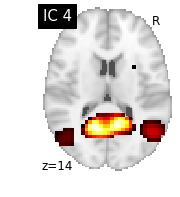

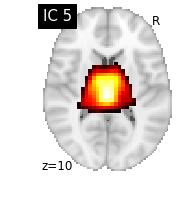

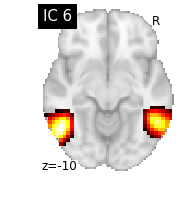

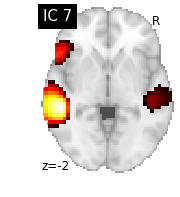

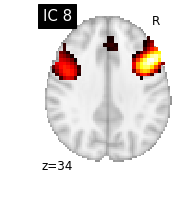

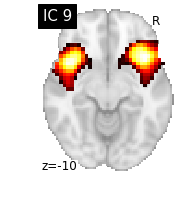

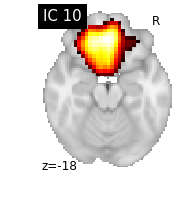

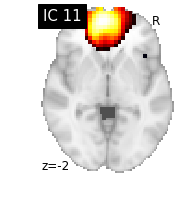

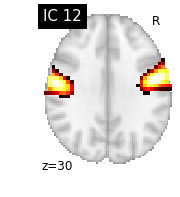

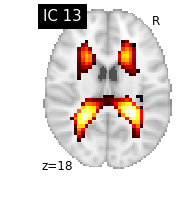

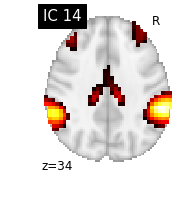

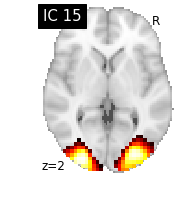

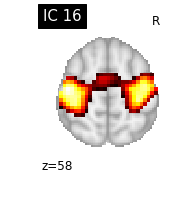

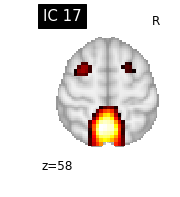

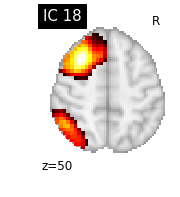

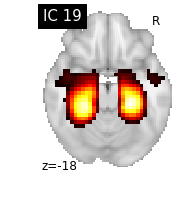

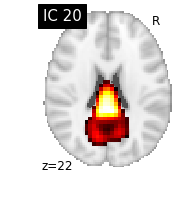

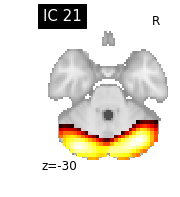

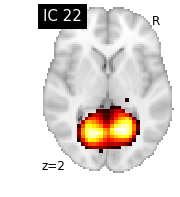

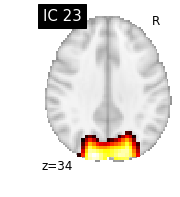

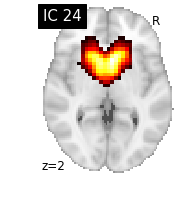

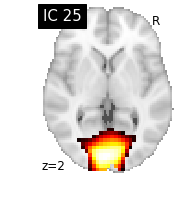

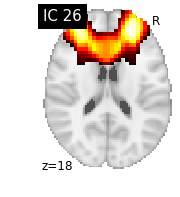

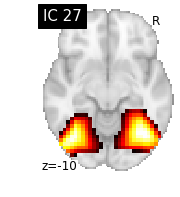

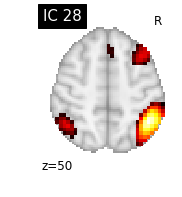

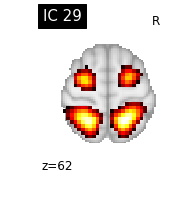

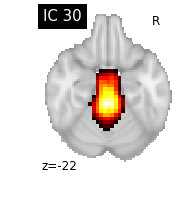

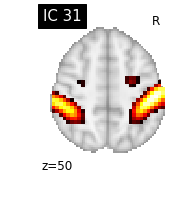

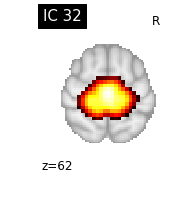

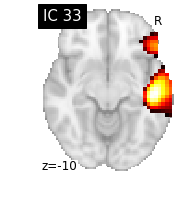

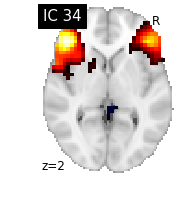

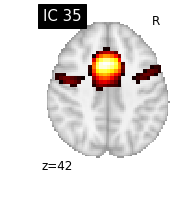

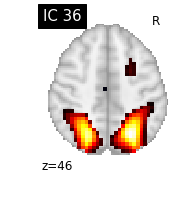

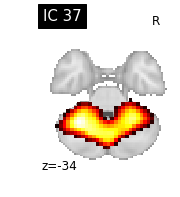

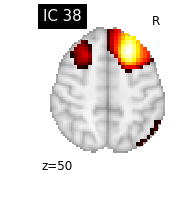

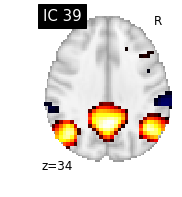

In [33]:
plot_net(clf.coef_.T  )
np.save('/home/uga_qinglin/Documents/ADHD_DL/ADHD200_DL_components.npy',clf.coef_.T,)